In [39]:
import os
import socket
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import *

In [2]:
try:
    spark
except NameError:
    spark = SparkSession.builder.appName("").getOrCreate()

In [3]:
if 'samuel' in socket.gethostname().lower():
    path_to_data = '../../data'
else:
    path_to_data = '/user/spf248/twitter/data'

In [4]:
print('Path to data:',path_to_data) 
country_code = "US"
print('Country:', country_code)
iterations=range(2)
models=['GLOVE','BERT']
labels=['is_hired_1mo', 'is_unemployed', 'job_offer', 'job_search', 'lost_job_1mo']
keywords=['fired', 'hired', 'job', 'laid_off', 'position', 'quit', 'unemployed', 'work']
targets=[
'target_anyone_hiring',
'target_here_is_a_job_opportunity_you_might_be_interested_in',
'target_i_am_currently_not_working',
'target_i_am_searching_for_a_new_position',
'target_i_got_hired_today',
'target_i_lost_my_job_today',
'target_i_recently_started_working_at_my_new_job',
'target_i_was_fired_earlier_this_week',
'target_looking_for_a_new_position',
'target_now_i_am_unemployed']

base_rates=[
1.7342911457049017e-05,
0.0003534645020523677,
0.005604641971672389,
0.00015839552996469054,
1.455338466552472e-05]
N_random=92114009
base_ranks=[int(x*N_random) for x in base_rates]
label2rank=dict(zip(labels,base_ranks))

Path to data: ../../data
Country: US


In [59]:
ranks=sorted(set([y+1 for x in np.logspace(1,6,11).astype(int) for y in range(x-10,x+10)]))
ranks=spark.createDataFrame(ranks, IntegerType()).withColumnRenamed('value','score_rank')
ranks.cache()

In [ ]:
random_tweets = spark.read.parquet(os.path.join(path_to_data,'classification',country_code,'random-scored'))
df = random_tweets.select('tweet_id','text')
df.cache()

In [ ]:
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            predictions=spark.read.option("header", "true").csv(os.path.join(path_to_data,'classification',country_code,'predictions','iteration_'+str(iteration),model,label,'random*'))
            tmp=predictions.withColumnRenamed('proba','score').withColumnRenamed('second','score').select('tweet_id','score')
            tmp=tmp.withColumn('score',F.col('score').cast('float'))
            tmp=tmp.withColumn("score_rank", F.row_number().over(Window.orderBy(F.desc("score"))))
            tmp=tmp.join(ranks,on="score_rank")
            tmp=tmp.join(df,on='tweet_id')
            tmp.coalesce(1).write.mode("overwrite").parquet(os.path.join(path_to_data,'classification',country_code,'sample_rank_score','iteration_'+str(iteration),model,label))

# Percentage of positives along the scores distribution

In [138]:
N_obs=220
N_block=20

In [139]:
sample_files=glob(os.path.join(path_to_data,'classification',country_code,'sample_rank_score','labeled','*'))

In [149]:
df={}
for iteration in iterations:
    print()
    print('********* Iteration:',iteration,'*********')
    for model in models:
        print()
        print('****** Model:',model,'******')
        for label in labels:
            print('*** Label:',label,'***')
            name='iteration_'+str(iteration)+'-'+model+'-'+label
            tmp_files=[f for f in sample_files if label in f and model.lower() in f.lower() and 'it'+str(iteration) in f]
            if len(tmp_files):
                print('#files:',len(tmp_files))
                tmp=pd.concat([pd.read_csv(f) for f in tmp_files]).sort_values(by='rank')
                tmp['index_rank']=pd.Series([y for x in range(N_obs//N_block) for y in [x]*N_block])
                if tmp.shape[0]!=N_obs:
                    print('Check N')
                    continue
                if 'label' not in tmp.columns:
                    print('Missing labels')
                    continue
                tmp['label']=tmp['label'].replace('ns',np.nan)
                tmp=tmp[['index_rank','rank','label']].copy()
                tmp.dropna(inplace=True)
                tmp=tmp.astype(float)
                df[name]=tmp.copy()
                print(df[name].shape[0])
            else:
                print('No file')


********* Iteration: 0 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
#files: 2
217
*** Label: is_unemployed ***
#files: 2
218
*** Label: job_offer ***
#files: 2
220
*** Label: job_search ***
#files: 2
220
*** Label: lost_job_1mo ***
#files: 2
219

****** Model: BERT ******
*** Label: is_hired_1mo ***
#files: 2
215
*** Label: is_unemployed ***
#files: 2
219
*** Label: job_offer ***
#files: 2
220
*** Label: job_search ***
#files: 2
219
*** Label: lost_job_1mo ***
#files: 2
220

********* Iteration: 1 *********

****** Model: GLOVE ******
*** Label: is_hired_1mo ***
#files: 1
216
*** Label: is_unemployed ***
#files: 1
217
*** Label: job_offer ***
#files: 1
220
*** Label: job_search ***
#files: 1
209
*** Label: lost_job_1mo ***
#files: 1
218

****** Model: BERT ******
*** Label: is_hired_1mo ***
#files: 2
204
*** Label: is_unemployed ***
#files: 2
202
*** Label: job_offer ***
#files: 2
220
*** Label: job_search ***
#files: 2
218
*** Label: lost_job_1mo ***
#files: 2
22

In [182]:
precisions=pd.read_csv(os.path.join(path_to_data,'classification',country_code,'precision_high_scored_tweets.csv'),index_col=0).set_index(['Iteration','Model','Label'])['Precision']

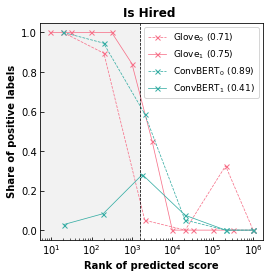

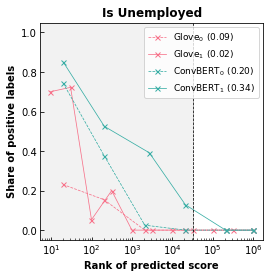

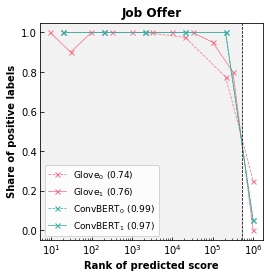

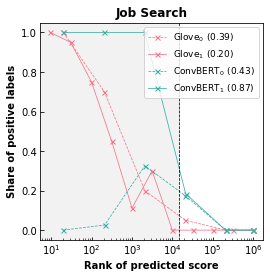

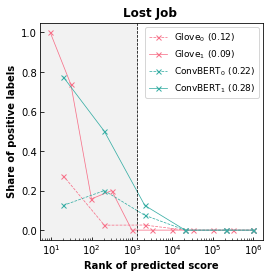

In [186]:
for label in labels:
    fig,ax = plt.subplots(figsize=(4,4))
    for i,model in enumerate(models):
        for j,iteration in enumerate(iterations):
            name='iteration_'+str(iteration)+'-'+model+'-'+label
            if name not in df:
                continue
            df[name].groupby('index_rank')[['rank','label']].mean().plot(
            y='label',
            x='rank',
            ax=ax,
            linewidth=.75,
            color=sns.color_palette("husl", len(models))[i],
            style=['--','-'][j],
            marker='x',
            markersize=5,
            label={'BERT':'ConvBERT','GLOVE':'Glove'}[model]+'$_'+str(iteration)+'$ ('+'{:.2f}'.format(precisions.loc[iteration,model,label])+')')
    ax.axvline(label2rank[label],linewidth=.75,color='k',linestyle='--')
    ax.set_xscale('log')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=6)
    ax.set_ylabel('Share of positive labels',fontweight='bold')
    ax.set_xlabel('Rank of predicted score',fontweight='bold')
    ax.axvspan(0, label2rank[label], alpha=0.1, color='grey')
    ax.set_title(label.replace('_',' ').replace('1mo','').title(),fontweight='bold')
    ax.legend(loc='best',fontsize=9)
    ax.set_ylim([-0.05,1.05])
    plt.savefig(os.path.join(path_to_data,'../fig','pred_pos_labels_'+label+'.pdf'),bbox_inches='tight')